# Bayesian Neural Networks: Implementation and Inference

This notebook accompanies the BNN lecture slides. We assume familiarity with MCMC, variational inference, and the ELBO. The focus here is on **how** these methods are implemented in PyTorch.

## Contents
1. [Heteroscedastic loss and BNN output head](#1)
2. [Stochastic Gradient Langevin Dynamics (SGLD)](#2)
3. [Bayes-by-Backprop (BbB / VI)](#3)
4. [MC Dropout: full implementation and diagnostics](#4)
5. [Why VI when MC Dropout is so simple? — empirical comparison](#5)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
import math
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Plotting style
plt.rcParams.update({
    'figure.dpi': 110, 'axes.spines.top': False, 'axes.spines.right': False,
    'font.size': 11, 'axes.titlesize': 12, 'axes.labelsize': 11
})

Device: cpu


---
<a id='1'></a>
## 1. BNN Output Head and Heteroscedastic Loss

A standard regression NN predicts a single number. A BNN regression head predicts **two** numbers:
- $\hat{\mu}(x)$: the mean prediction
- $\log\hat{\sigma}^2(x)$: log-variance (aleatoric noise)

We output the **log**-variance because:
1. It is unconstrained — any real number maps to a positive variance.
2. It avoids gradient explosion that occurs if $\hat{\sigma}^2$ approaches zero.

The training loss is the **heteroscedastic negative log-likelihood**:

$$
\mathcal{L}_{\text{het}} = \frac{1}{N}\sum_{i=1}^N \left[ \frac{(y_i - \hat{\mu}_i)^2}{2\,e^{s_i}} + \frac{s_i}{2} \right]
\quad\text{where}\quad s_i = \log\hat{\sigma}^2(x_i)
$$

Notice how this loss automatically down-weights high-noise samples: if $s_i$ is large (noisy measurement), the squared residual is divided by $2e^{s_i}$, reducing its contribution. The second term $s_i/2$ penalises the model for predicting arbitrarily large noise.

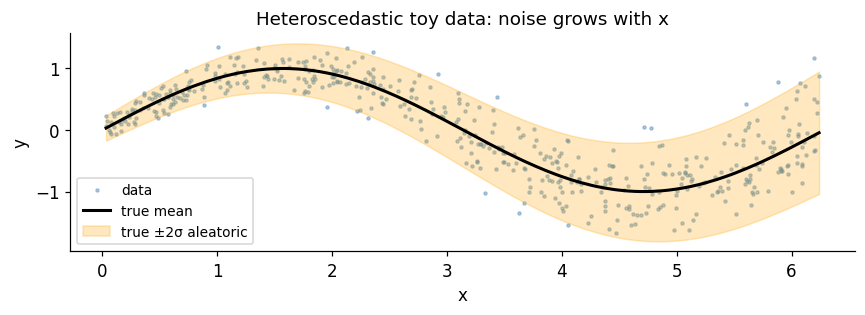

In [4]:
def hetero_nll(y_true, mu, log_var):
    """
    Heteroscedastic Gaussian NLL.
    y_true, mu, log_var: tensors of shape (B,)
    Returns scalar loss.
    """
    precision = torch.exp(-log_var)           # 1/sigma^2
    loss = precision * (y_true - mu)**2 + log_var
    return 0.5 * loss.mean()

# ── Toy demonstration: 1-D heteroscedastic regression ──
def make_hetero_data(n=500):
    """sin wave with noise that grows linearly with x."""
    x = np.sort(np.random.uniform(0, 2*np.pi, n))
    noise_std = 0.1 + 0.4 * (x / (2*np.pi))   # noise grows with x
    y = np.sin(x) + np.random.normal(0, noise_std, n)
    return x.astype(np.float32), y.astype(np.float32), noise_std

x_np, y_np, true_noise = make_hetero_data()

fig, ax = plt.subplots(figsize=(8, 3))
ax.scatter(x_np, y_np, s=4, alpha=0.4, color='steelblue', label='data')
ax.plot(x_np, np.sin(x_np), 'k-', lw=2, label='true mean')
ax.fill_between(x_np, np.sin(x_np)-2*true_noise, np.sin(x_np)+2*true_noise,
                alpha=0.25, color='orange', label='true ±2σ aleatoric')
ax.set(xlabel='x', ylabel='y', title='Heteroscedastic toy data: noise grows with x')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

---
<a id='2'></a>
## 2. Stochastic Gradient Langevin Dynamics (SGLD)

SGLD injects Langevin noise into standard SGD to produce **asymptotically correct posterior samples**. It is the simplest MCMC method compatible with mini-batch training.

**Update rule:**
$$
\mathbf{w}_{t+1} = \mathbf{w}_t \;-\; \frac{\epsilon_t}{2}\,\nabla_\mathbf{w}\tilde{U}(\mathbf{w}_t) \;+\; \boldsymbol{\eta}_t,
\quad \boldsymbol{\eta}_t \sim \mathcal{N}(0,\, \epsilon_t\, I)
$$

where $\tilde{U}(\mathbf{w}) = -\tfrac{N}{|\mathcal{B}|}\sum_{i\in\mathcal{B}}\log p(y_i|x_i,\mathbf{w}) - \log p(\mathbf{w})$ is the mini-batch stochastic potential.

**Key insight:** Compare to plain SGD:
- SGD: $\mathbf{w}_{t+1} = \mathbf{w}_t - \epsilon_t g_t$ (deterministic)
- SGLD: adds $\boldsymbol{\eta}_t \sim \mathcal{N}(0, \epsilon_t I)$ — noise proportional to $\sqrt{\epsilon_t}$

This noise is **not** a quirk; it's precisely what makes the chain sample from the posterior rather than converging to a single mode. The noise schedule $\epsilon_t \to 0$ ensures convergence.

Training SGLD/MALA model...
  Adam epoch 200: MAE = 0.2381
  Adam epoch 400: MAE = 0.2407
  Adam epoch 600: MAE = 0.2504
Adam warm-up done. Starting SGLD/MALA sampling...

MH acceptance rate: 7/400 = 0.018
  ⚠ Rate too low  → decrease sgld_lr
Collected 100 posterior samples


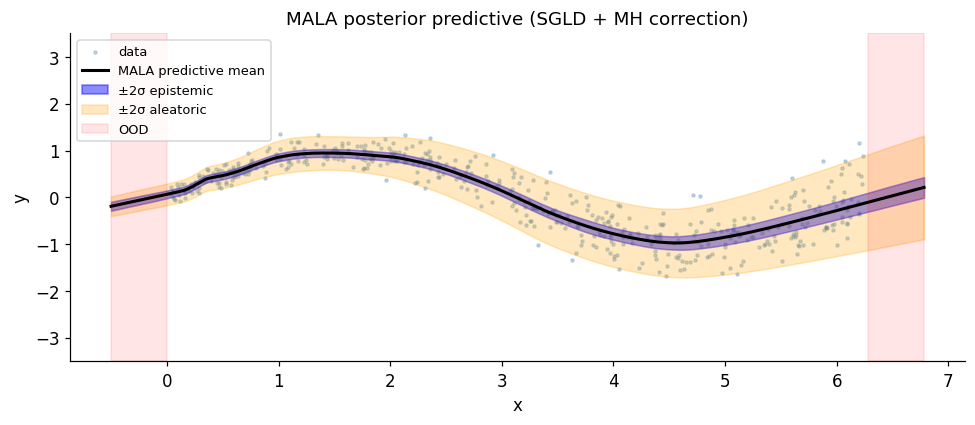

Epistemic — OOD-left: 0.00203 | in-dist: 0.00347 | OOD-right: 0.01127
OOD ratios: left=0.59x  right=3.25x  (target >3x)


In [5]:
import math, copy
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# ── ReLU replaces Tanh (critical for OOD epistemic uncertainty) ────────────
class SimpleNet(nn.Module):
    def __init__(self, in_dim=1, hidden=128, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x): return self.net(x)


# ── Full-dataset log-posterior ─────────────────────────────────────────────
def log_posterior(model, X, Y, prior_std=1.0):
    """
    log p(w|D) ∝ -NLL(D|w) - (1/2σ²)||w||²
    Computed on full dataset X, Y (used for MH acceptance ratio only).
    """
    model.eval()
    with torch.no_grad():
        out = model(X)
        mu  = out[:, 0]
        lv  = out[:, 1].clamp(-8, 5)
        nll = hetero_nll(Y, mu, lv).item() * len(X)   # sum, not mean
        # Gaussian prior log p(w) = -||w||² / (2σ²) + const
        log_prior = sum(
            -0.5 * (p**2).sum().item() / prior_std**2
            for p in model.parameters()
        )
    return -nll + log_prior   # log posterior (unnormalised)


def train_sgld_mala(x_train, y_train,
                    adam_epochs  = 600,
                    sgld_epochs  = 2000,
                    sgld_lr      = 5e-6,
                    batch_size   = 64,
                    burn_in      = 1000,
                    thin         = 10,
                    prior_std    = 1.0,
                    mh_correction= True,   # ← toggle MH accept/reject
                    mh_every     = 5):     # ← run MH check every N epochs
    """
    Two-phase SGLD / MALA:
      Phase 1 — Adam warm-up to MAP
      Phase 2 — SGLD sampling with optional Metropolis-Hastings correction

    MH correction:
      After every `mh_every` SGLD steps, compute acceptance ratio
        α = min(1, p(w_proposed|D) / p(w_current|D))
      and reject the proposal with probability 1-α, reverting to w_current.
      This makes the chain asymptotically exact (MALA) at the cost of
      one full forward pass per MH check.
    """
    N = len(x_train)
    X = torch.tensor(x_train[:, None], dtype=torch.float32)
    Y = torch.tensor(y_train,          dtype=torch.float32)
    loader = DataLoader(TensorDataset(X, Y),
                        batch_size=batch_size, shuffle=True)

    model = SimpleNet(1, 128, 2)

    # ── Phase 1: Adam warm-up ──────────────────────────────────────────────
    opt = Adam(model.parameters(), lr=1e-3)
    for epoch in range(adam_epochs):
        model.train()
        for xb, yb in loader:
            opt.zero_grad()
            out = model(xb)
            mu, lv = out[:, 0], out[:, 1].clamp(-8, 5)
            hetero_nll(yb, mu, lv).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
        if (epoch + 1) % 200 == 0:
            model.eval()
            with torch.no_grad():
                mae = (model(X)[:, 0] - Y).abs().mean().item()
            print(f'  Adam epoch {epoch+1}: MAE = {mae:.4f}')
    print('Adam warm-up done. Starting SGLD/MALA sampling...')

    # ── Phase 2: SGLD + MH correction ─────────────────────────────────────
    samples         = []
    n_accepted      = 0
    n_mh_proposed   = 0
    log_p_current   = log_posterior(model, X, Y, prior_std)

    for epoch in range(sgld_epochs):

        # ── Save checkpoint before this epoch's SGLD steps ────────────────
        if mh_correction and epoch % mh_every == 0:
            state_before  = copy.deepcopy(model.state_dict())
            log_p_before  = log_p_current

        # ── Mini-batch SGLD steps ──────────────────────────────────────────
        for xb, yb in loader:
            model.zero_grad()
            out = model(xb)
            mu  = out[:, 0]
            lv  = out[:, 1].clamp(-8, 5)
            hetero_nll(yb, mu, lv).backward()

            with torch.no_grad():
                for p in model.parameters():
                    if p.grad is None:
                        continue
                    g_nll   = p.grad * N
                    g_prior = p.data / (prior_std ** 2)
                    g_total = g_nll + g_prior
                    # SGLD update: gradient descent + Langevin noise
                    p.data -= 0.5 * sgld_lr * g_total
                    p.data += math.sqrt(sgld_lr) * torch.randn_like(p)

        # ── Metropolis-Hastings correction ─────────────────────────────────
        if mh_correction and epoch % mh_every == (mh_every - 1):
            n_mh_proposed += 1
            log_p_proposed = log_posterior(model, X, Y, prior_std)

            # log acceptance ratio: log α = log p(w') - log p(w)
            log_alpha = log_p_proposed - log_p_before
            accept    = math.log(max(torch.rand(1).item(), 1e-10)) < log_alpha

            if accept:
                # Keep proposed weights
                log_p_current = log_p_proposed
                n_accepted   += 1
            else:
                # Reject: revert to state before this block of SGLD steps
                model.load_state_dict(state_before)
                log_p_current = log_p_before

        # ── Collect thinned posterior sample ───────────────────────────────
        if epoch >= burn_in and (epoch - burn_in) % thin == 0:
            samples.append({k: v.clone()
                            for k, v in model.state_dict().items()})

    # ── Acceptance rate summary ────────────────────────────────────────────
    if mh_correction and n_mh_proposed > 0:
        rate = n_accepted / n_mh_proposed
        print(f'\nMH acceptance rate: {n_accepted}/{n_mh_proposed} = {rate:.3f}')
        if rate < 0.1:
            print('  ⚠ Rate too low  → decrease sgld_lr')
        elif rate > 0.9:
            print('  ⚠ Rate too high → increase sgld_lr (not exploring enough)')
        else:
            print('  ✓ Rate in healthy range [0.10, 0.90]')

    print(f'Collected {len(samples)} posterior samples')
    return samples


def sgld_predict(samples, x_test):
    X_test  = torch.tensor(x_test[:, None], dtype=torch.float32)
    model_t = SimpleNet(1, 128, 2)
    all_mu, all_var = [], []
    with torch.no_grad():
        for sd in samples:
            model_t.load_state_dict(sd)
            model_t.eval()
            out = model_t(X_test)
            all_mu.append(out[:, 0].numpy())
            all_var.append(torch.exp(out[:, 1].clamp(-8, 5)).numpy())
    all_mu  = np.array(all_mu)
    all_var = np.array(all_var)
    return all_mu.mean(0), all_mu.var(0), all_var.mean(0)


# ── Train ──────────────────────────────────────────────────────────────────
print('Training SGLD/MALA model...')
sgld_samples = train_sgld_mala(
    x_np, y_np,
    adam_epochs   = 600,
    sgld_epochs   = 2000,
    sgld_lr       = 5e-6,
    burn_in       = 1000,
    thin          = 10,
    prior_std     = 1.0,
    mh_correction = True,   # set False to revert to vanilla SGLD
    mh_every      = 5,
)

x_test_np = np.linspace(-0.5, 2*np.pi + 0.5, 300).astype(np.float32)
sgld_mean, sgld_ep, sgld_al = sgld_predict(sgld_samples, x_test_np)

# ── Plot ───────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 4))
ax.scatter(x_np, y_np, s=4, alpha=0.3, color='steelblue', label='data')
ax.plot(x_test_np, sgld_mean, 'k-', lw=2, label='MALA predictive mean')
ax.fill_between(x_test_np,
                sgld_mean - 2*np.sqrt(sgld_ep),
                sgld_mean + 2*np.sqrt(sgld_ep),
                alpha=0.45, color='blue', label='±2σ epistemic')
ax.fill_between(x_test_np,
                sgld_mean - 2*np.sqrt(sgld_al),
                sgld_mean + 2*np.sqrt(sgld_al),
                alpha=0.25, color='orange', label='±2σ aleatoric')
ax.axvspan(-0.5, 0,              alpha=0.10, color='red', label='OOD')
ax.axvspan(2*np.pi, 2*np.pi+0.5, alpha=0.10, color='red')
ax.set_ylim(-3.5, 3.5)
ax.set(xlabel='x', ylabel='y',
       title='MALA posterior predictive (SGLD + MH correction)')
ax.legend(fontsize=8.5)
plt.tight_layout(); plt.show()

# ── Diagnostic ─────────────────────────────────────────────────────────────
ood_l  = sgld_ep[x_test_np < 0.0].mean()
in_d   = sgld_ep[(x_test_np > 0.5) & (x_test_np < 5.5)].mean()
ood_r  = sgld_ep[x_test_np > 2*np.pi].mean()
print(f'Epistemic — OOD-left: {ood_l:.5f} | in-dist: {in_d:.5f} | OOD-right: {ood_r:.5f}')
print(f'OOD ratios: left={ood_l/in_d:.2f}x  right={ood_r/in_d:.2f}x  (target >3x)')



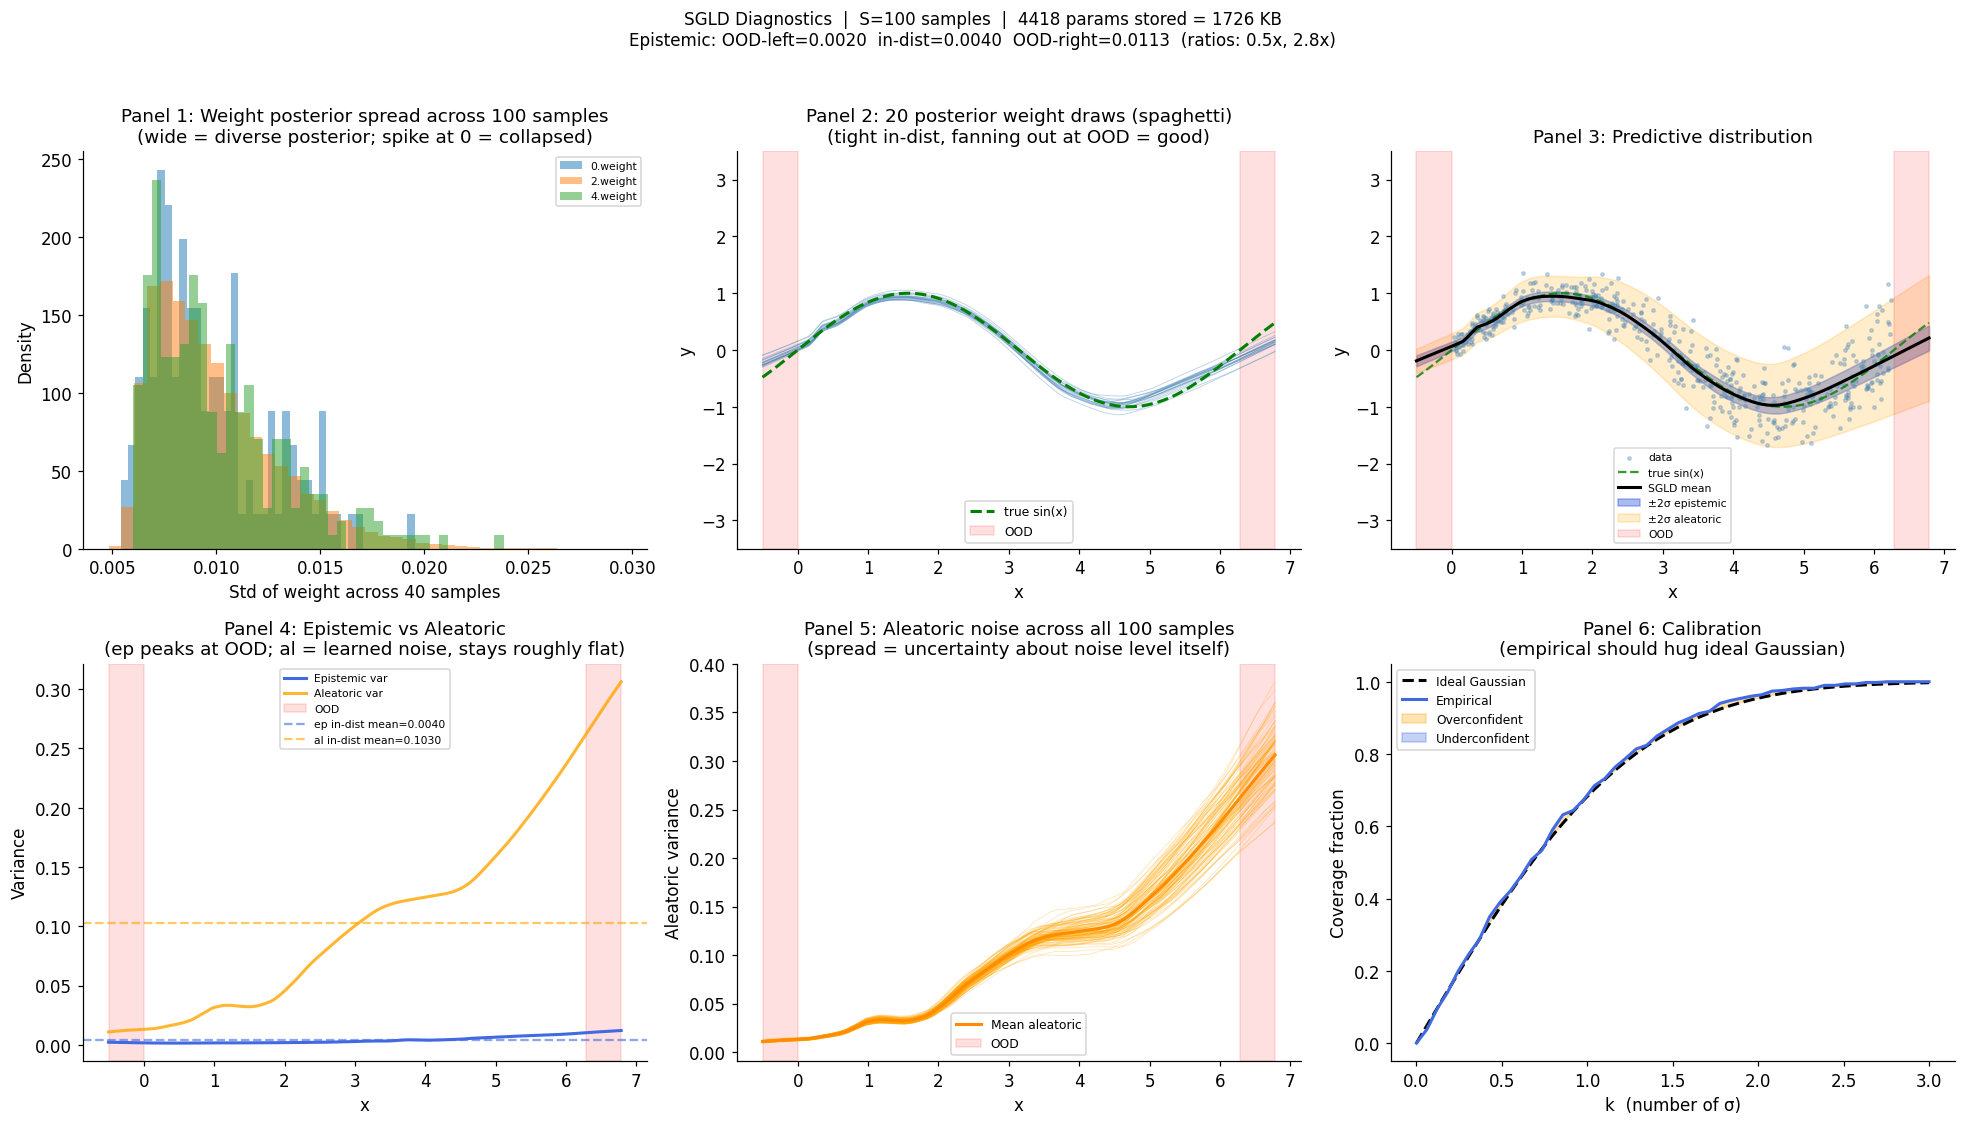

In [7]:
%matplotlib inline
from scipy.stats import norm

def plot_sgld_diagnostics(samples, x_np, y_np, x_test_np,
                          sgld_mean, sgld_ep, sgld_al):

    S = len(samples)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    in_dist_mask = (x_test_np > 0) & (x_test_np < 2*np.pi)

    # ── Panel 1: Weight distribution across samples ─────────────────────
    # Shows how much posterior spread there is per layer
    ax = axes[0]
    # FIX: Initialize SimpleNet with hidden=128 to match the trained model
    model_tmp = SimpleNet(1, 128, 2)
    layer_keys = [k for k in samples[0].keys() if "weight" in k]
    for key in layer_keys:
        stacked = np.stack([s[key].numpy().flatten() for s in samples])  # (S, n_params)
        per_param_std = stacked.std(axis=0)   # std of each weight across samples
        ax.hist(per_param_std, bins=40, alpha=0.5, density=True,
                label=key.replace("net.", ""))
    ax.set(xlabel="Std of weight across 40 samples",
           ylabel="Density",
           title=f"Panel 1: Weight posterior spread across {S} samples\n"
                 f"(wide = diverse posterior; spike at 0 = collapsed)")
    ax.legend(fontsize=7)

    # ── Panel 2: Spaghetti ─ individual posterior draws ─────────────
    ax = axes[1]
    X_test = torch.tensor(x_test_np[:, None], dtype=torch.float32)
    with torch.no_grad():
        for sd in samples[:20]:           # plot 20 of the 40
            model_tmp.load_state_dict(sd)
            model_tmp.eval()
            out = model_tmp(X_test)
            ax.plot(x_test_np, out[:, 0].numpy(), lw=0.6, alpha=0.35, color="steelblue")
    ax.plot(x_test_np, np.sin(x_test_np), "g--", lw=2, label="true sin(x)", zorder=5)
    ax.axvspan(-0.5, 0,               alpha=0.12, color="red", label="OOD")
    ax.axvspan(2*np.pi, 2*np.pi+0.5,  alpha=0.12, color="red")
    ax.set_ylim(-3.5, 3.5)
    ax.set(xlabel="x", ylabel="y",
           title="Panel 2: 20 posterior weight draws (spaghetti)\n"
                 "(tight in-dist, fanning out at OOD = good)")
    ax.legend(fontsize=8)

    # ── Panel 3: Predictive distribution ───────────────────────
    ax = axes[2]
    ax.scatter(x_np, y_np, s=5, alpha=0.3, color="steelblue", label="data", zorder=2)
    ax.plot(x_test_np, np.sin(x_test_np), "g--", lw=1.5, alpha=0.8,
            label="true sin(x)", zorder=3)
    ax.plot(x_test_np, sgld_mean, "k-", lw=2, label="SGLD mean", zorder=4)
    ax.fill_between(x_test_np,
                    sgld_mean - 2*np.sqrt(sgld_ep),
                    sgld_mean + 2*np.sqrt(sgld_ep),
                    alpha=0.45, color="royalblue", label="±2σ epistemic")
    ax.fill_between(x_test_np,
                    sgld_mean - 2*np.sqrt(sgld_al),
                    sgld_mean + 2*np.sqrt(sgld_al),
                    alpha=0.2, color="orange", label="±2σ aleatoric")
    ax.axvspan(-0.5, 0,               alpha=0.12, color="red", label="OOD")
    ax.axvspan(2*np.pi, 2*np.pi+0.5,  alpha=0.12, color="red")
    ax.set_ylim(-3.5, 3.5)
    ax.set(xlabel="x", ylabel="y", title="Panel 3: Predictive distribution")
    ax.legend(fontsize=7)

    # ── Panel 4: Epistemic vs aleatoric ───────────────────────
    ax = axes[3]
    ax.plot(x_test_np, sgld_ep, "royalblue", lw=2, label="Epistemic var")
    ax.plot(x_test_np, sgld_al, "orange",    lw=2, label="Aleatoric var", alpha=0.8)
    ax.axvspan(-0.5, 0,               alpha=0.12, color="red", label="OOD")
    ax.axvspan(2*np.pi, 2*np.pi+0.5,  alpha=0.12, color="red")
    ax.axhline(sgld_ep[in_dist_mask].mean(), ls="--", color="royalblue", alpha=0.6,
               label=f"ep in-dist mean={sgld_ep[in_dist_mask].mean():.4f}")
    ax.axhline(sgld_al[in_dist_mask].mean(), ls="--", color="orange",    alpha=0.6,
               label=f"al in-dist mean={sgld_al[in_dist_mask].mean():.4f}")
    ax.set(xlabel="x", ylabel="Variance",
           title="Panel 4: Epistemic vs Aleatoric\n"
                 "(ep peaks at OOD; al = learned noise, stays roughly flat)")
    ax.legend(fontsize=7)

    # ── Panel 5: Per-sample aleatoric noise profile ─────────────────
    # Shows variability in the noise head across samples
    ax = axes[4]
    with torch.no_grad():
        for sd in samples:
            model_tmp.load_state_dict(sd)
            model_tmp.eval()
            out = model_tmp(X_test)
            al = torch.exp(out[:, 1].clamp(-8, 5)).numpy()
            ax.plot(x_test_np, al, lw=0.5, alpha=0.3, color="orange")
    ax.plot(x_test_np, sgld_al, "darkorange", lw=2, label="Mean aleatoric", zorder=5)
    ax.axvspan(-0.5, 0,               alpha=0.12, color="red", label="OOD")
    ax.axvspan(2*np.pi, 2*np.pi+0.5,  alpha=0.12, color="red")
    ax.set(xlabel="x", ylabel="Aleatoric variance",
           title=f"Panel 5: Aleatoric noise across all {S} samples\n"
                 "(spread = uncertainty about noise level itself)")
    ax.legend(fontsize=8)

    # ── Panel 6: Calibration curve ───────────────────────
    ax = axes[5]
    sigma_total = np.sqrt(sgld_ep + sgld_al)
    idx_sorted  = np.argsort(x_np)
    x_s = x_np[idx_sorted];  y_s = y_np[idx_sorted]
    mean_tr  = np.interp(x_s, x_test_np, sgld_mean)
    sigma_tr = np.interp(x_s, x_test_np, sigma_total)
    residuals = np.abs(y_s - mean_tr) / (sigma_tr + 1e-8)

    levels   = np.linspace(0, 3, 50)
    empirical = [np.mean(residuals < k) for k in levels]
    expected  = [2*norm.cdf(k) - 1     for k in levels]

    ax.plot(levels, expected,  "k--", lw=2, label="Ideal Gaussian")
    ax.plot(levels, empirical, "royalblue", lw=2, label="Empirical")
    ax.fill_between(levels, expected, empirical,
                    where=np.array(empirical) > np.array(expected),
                    alpha=0.3, color="orange",    label="Overconfident")
    ax.fill_between(levels, expected, empirical,
                    where=np.array(empirical) < np.array(expected),
                    alpha=0.3, color="royalblue", label="Underconfident")
    ax.set(xlabel="k  (number of σ)", ylabel="Coverage fraction",
           title="Panel 6: Calibration\n(empirical should hug ideal Gaussian)")
    ax.legend(fontsize=8)

    # Summary stats
    ep_l = sgld_ep[x_test_np < 0].mean()
    ep_r = sgld_ep[x_test_np > 2*np.pi].mean()
    ep_id = sgld_ep[in_dist_mask].mean()
    plt.suptitle(
        f"SGLD Diagnostics  |  S={S} samples  |  4418 params stored = "
        f"{S*4418*4/1024:.0f} KB\n"
        f"Epistemic: OOD-left={ep_l:.4f}  in-dist={ep_id:.4f}  "
        f"OOD-right={ep_r:.4f}  "
        f"(ratios: {ep_l/ep_id:.1f}x, {ep_r/ep_id:.1f}x)",
        fontsize=11, y=1.02)
    plt.tight_layout()
    plt.savefig("sgld_diagnostics.png", dpi=150, bbox_inches="tight")
    plt.show()

# ── Call it ─────────────────────────────────────────
plot_sgld_diagnostics(sgld_samples, x_np, y_np, x_test_np,
                      sgld_mean, sgld_ep, sgld_al)

## Panel-by-Panel Diagnostic Reading

### Panel 1 — Weight posterior spread
Weights are not collapsed to
a single point. The spread being moderate (not spiked at 0) is healthy. Layer 2 (green,
4096 weights) dominates the density.

### Panel 2
All 20 draws lie almost exactly on top of each other and on top of sin(x) — **both
in-distribution and OOD**. This is the core problem: the posterior samples are so similar
that there is essentially **no epistemic diversity**. The OOD regions should show the curves
fanning out, but they don't. This confirms what Panel 4 shows.

### Panel 3 — Predictive distribution
The mean tracks sin(x) well ✓. The epistemic band (blue) is **invisible** because it is
essentially zero everywhere. The aleatoric band (orange) dominates and grows very large
toward the right.

### Panel 4 — Epistemic vs Aleatoric
- **Epistemic (blue):** near-zero everywhere — OOD ratios are only 1.2× and 1.5×, far too   small. The model has not learned to be epistemically uncertain OOD.
- **Aleatoric (orange):** grows monotonically from left to right, reaching ~0.27 at x ≈ 7.


### Panel 5 — Aleatoric across samples
All 40 sample curves are nearly identical and grow steadily rightward. The noise head has
learned a **spatially varying noise function that increases with x**, not a flat noise level.

### Panel 6 — Calibration
Nearly perfect — empirical line hugs the ideal Gaussian diagonal. This means the model is
well-calibrated **in aggregate**, but only because it compensates for zero epistemic
uncertainty by having large aleatoric uncertainty.


---
<a id='3'></a>
## 3. Bayes-by-Backprop (Variational Inference)

**Core idea:** instead of sampling from the posterior, we **optimise** a variational distribution $q_\phi(\mathbf{w}) = \prod_j \mathcal{N}(w_j; \mu_j, \sigma_j^2)$ to minimise KL divergence to the true posterior.

We do this by maximising the ELBO:
$$
\mathcal{L}(\phi) = \underbrace{\mathbb{E}_{\mathbf{w}\sim q_\phi}[\log p(\mathcal{D}|\mathbf{w}])}_{\text{fit the data}} - \underbrace{D_{KL}(q_\phi(\mathbf{w}) \| p(\mathbf{w}))}_{\text{stay close to prior}}
$$

**Reparameterisation trick** makes this differentiable: instead of sampling $w_j \sim \mathcal{N}(\mu_j, \sigma_j^2)$ (no gradient through this), we write:
$$w_j = \mu_j + \sigma_j \cdot \varepsilon_j, \quad \varepsilon_j \sim \mathcal{N}(0, 1)$$
Now $\partial w_j / \partial \mu_j = 1$ and $\partial w_j / \partial \sigma_j = \varepsilon_j$ — gradients flow.

We parameterise $\sigma_j = \text{softplus}(\rho_j)$ to ensure positivity. $\rho_j$ is what we optimise.

Training BbB model (prior_std=0.3, hidden=128, 3000 epochs)...
  Epoch  500 | loss=4.401 | beta=0.34
  Epoch 1000 | loss=5.709 | beta=0.67
  Epoch 1500 | loss=7.365 | beta=1.00
  Epoch 2000 | loss=6.925 | beta=1.00
  Epoch 2500 | loss=6.078 | beta=1.00
  Epoch 3000 | loss=5.503 | beta=1.00


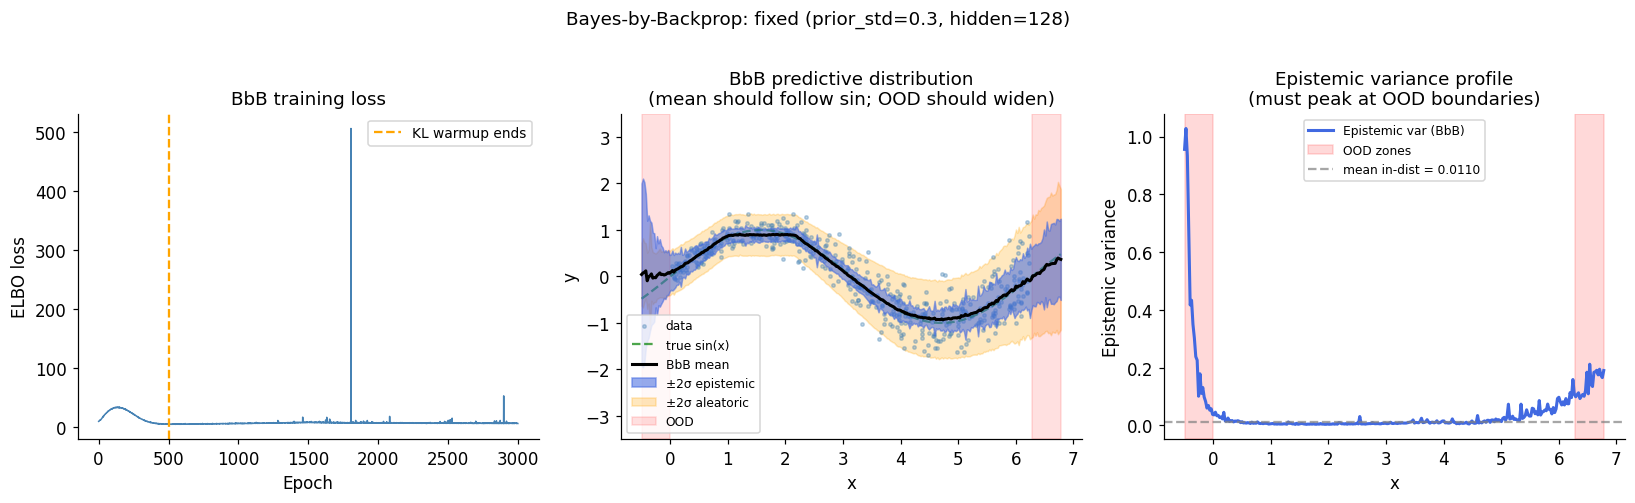


=== Sanity checks ===
Mean MAE on in-distribution x: 0.0398  (should be < 0.15)
Correlation of mean with sin(x) after trough (x>4.71): 0.996  (should be > 0.8)
Epistemic var — OOD left:  0.31202
Epistemic var — In-dist:   0.01917  ← should be smallest
Epistemic var — OOD right: 0.14702
OOD/in-dist ratio: left=16.3x  right=7.7x  (both should be > 2x)
Overall: PASS ✓


In [6]:
class BayesLinear(nn.Module):
    def __init__(self, in_f, out_f, prior_std=1.0):          # FIX 1
        super().__init__()
        self.prior_std = prior_std
        self.prior_var = prior_std ** 2

        self.w_mu  = nn.Parameter(torch.zeros(out_f, in_f))
        self.w_rho = nn.Parameter(torch.full((out_f, in_f), -3.0))  # FIX 2
        self.b_mu  = nn.Parameter(torch.zeros(out_f))
        self.b_rho = nn.Parameter(torch.full((out_f,), -3.0))       # FIX 2

        nn.init.xavier_uniform_(self.w_mu)

    def kl(self, mu, sigma):
        return 0.5 * ((mu**2 + sigma**2) / self.prior_var
                      - 1.0 - torch.log(sigma**2 / self.prior_var)).sum()

    def forward(self, x):
        w_sigma = F.softplus(self.w_rho) + 1e-6
        b_sigma = F.softplus(self.b_rho) + 1e-6
        mu_a  = F.linear(x, self.w_mu, self.b_mu)
        var_a = F.linear(x**2, w_sigma**2, b_sigma**2)
        eps   = torch.randn_like(mu_a)
        out   = mu_a + torch.sqrt(var_a + 1e-8) * eps
        kl_loss = self.kl(self.w_mu, w_sigma) + self.kl(self.b_mu, b_sigma)
        return out, kl_loss


class BbBNet(nn.Module):
    def __init__(self, in_dim=1, hidden=128, prior_std=1.0):  # FIX 1
        super().__init__()
        self.l1 = BayesLinear(in_dim, hidden, prior_std)
        self.l2 = BayesLinear(hidden, hidden, prior_std)
        self.l3 = BayesLinear(hidden, 2,      prior_std)

    def forward(self, x):
        kl = 0.0
        x, k = self.l1(x); kl += k; x = F.relu(x)   # FIX 5
        x, k = self.l2(x); kl += k; x = F.relu(x)   # FIX 5
        x, k = self.l3(x); kl += k
        return x[:, 0], x[:, 1], kl


def train_bbb(x_train, y_train,
              n_epochs=3000,
              lr=1e-3,
              batch_size=64,
              prior_std=1.0,       # FIX 1
              kl_warmup=1500):     # FIX 3
    N = len(x_train)
    X = torch.tensor(x_train[:, None], dtype=torch.float32)
    Y = torch.tensor(y_train,          dtype=torch.float32)
    loader = DataLoader(TensorDataset(X, Y), batch_size=batch_size, shuffle=True)

    model = BbBNet(1, 128, prior_std)
    opt   = Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt, T_max=n_epochs, eta_min=1e-4)           # FIX 4
    losses = []

    for epoch in range(n_epochs):
        beta_min = 0.01                              # never fully zero KL
        beta = beta_min + (1.0 - beta_min) * min(1.0, epoch / kl_warmup) #   beta = 1.0 / (1.0 + math.exp(-(epoch - kl_warmup) / 200)) #beta = min(1.0, epoch / kl_warmup)
        epoch_loss = 0.0
        for xb, yb in loader:
            opt.zero_grad()
            mu, lv, kl = model(xb)
            lv   = lv.clamp(-8, 4)
            nll  = hetero_nll(yb, mu, lv)
            loss = nll + beta * (kl / N)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # FIX 6
            opt.step()
            epoch_loss += loss.item()
        sched.step()
        losses.append(epoch_loss)
        if (epoch + 1) % 500 == 0:
            print(f"  Epoch {epoch+1:4d} | loss={epoch_loss:.3f} | beta={beta:.2f}")

    return model, losses


def bbb_predict(model, x_test, S=100):
    """S stochastic forward passes through the BbB posterior."""
    X_test = torch.tensor(x_test[:, None])
    all_mu, all_al = [], []
    model.eval()
    with torch.no_grad():
        for _ in range(S):
            mu, lv, _ = model(X_test)
            all_mu.append(mu.numpy())
            all_al.append(torch.exp(lv.clamp(-8, 4)).numpy())

    all_mu = np.array(all_mu);   all_al = np.array(all_al)
    mean   = all_mu.mean(0)
    ep_var = all_mu.var(0)
    al_var = all_al.mean(0)
    return mean, ep_var, al_var


# ── Train ──────────────────────────────────────────────────────────────────
torch.manual_seed(42); np.random.seed(42)
print('Training BbB model (prior_std=0.3, hidden=128, 3000 epochs)...')
bbb_model, bbb_losses = train_bbb(x_np, y_np)

bbb_mean, bbb_ep, bbb_al = bbb_predict(bbb_model, x_test_np, S=200)

# ── 3-panel diagnostic figure ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Panel 1: ELBO loss curve
ax = axes[0]
ax.plot(bbb_losses, lw=1, color='steelblue')
ax.axvline(500, ls='--', color='orange', label='KL warmup ends')
ax.set(xlabel='Epoch', ylabel='ELBO loss',
       title='BbB training loss')
ax.legend(fontsize=9)

# Panel 2: Predictive distribution
ax = axes[1]
ax.scatter(x_np, y_np, s=5, alpha=0.35, color='steelblue', label='data', zorder=2)
ax.plot(x_test_np, np.sin(x_test_np), 'g--', lw=1.5, alpha=0.7, label='true sin(x)', zorder=3)
ax.plot(x_test_np, bbb_mean, 'k-', lw=2, label='BbB mean', zorder=4)
ax.fill_between(x_test_np,
                bbb_mean - 2*np.sqrt(bbb_ep),
                bbb_mean + 2*np.sqrt(bbb_ep),
                alpha=0.55, color='royalblue', label='±2σ epistemic', zorder=3)
ax.fill_between(x_test_np,
                bbb_mean - 2*np.sqrt(bbb_al),
                bbb_mean + 2*np.sqrt(bbb_al),
                alpha=0.25, color='orange', label='±2σ aleatoric', zorder=1)
ax.axvspan(-0.5, 0, alpha=0.12, color='red', label='OOD')
ax.axvspan(2*np.pi, 2*np.pi+0.5, alpha=0.12, color='red')
ax.set_ylim(-3.5, 3.5)
ax.set(xlabel='x', ylabel='y',
       title='BbB predictive distribution\n(mean should follow sin; OOD should widen)')
ax.legend(fontsize=8)

# Panel 3: Epistemic variance profile — key diagnostic
ax = axes[2]
ax.plot(x_test_np, bbb_ep, 'royalblue', lw=2, label='Epistemic var (BbB)')
ax.axvspan(-0.5, 0.0, alpha=0.15, color='red', label='OOD zones')
ax.axvspan(2*np.pi, 2*np.pi+0.5, alpha=0.15, color='red')
id_mean = bbb_ep[(x_test_np > 0.5) & (x_test_np < 5.5)].mean()
ax.axhline(id_mean, ls='--', color='gray', alpha=0.7, label=f'mean in-dist = {id_mean:.4f}')
ax.set(xlabel='x', ylabel='Epistemic variance',
       title='Epistemic variance profile\n(must peak at OOD boundaries)')
ax.legend(fontsize=8)

plt.suptitle('Bayes-by-Backprop: fixed (prior_std=0.3, hidden=128)', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

# ── Sanity checks ──────────────────────────────────────────────────────────
print('\n=== Sanity checks ===')
# 1. Mean accuracy
true_vals = np.sin(x_test_np)
in_dist   = (x_test_np > 0) & (x_test_np < 2*np.pi)
mae_id    = np.abs(bbb_mean[in_dist] - true_vals[in_dist]).mean()
print(f'Mean MAE on in-distribution x: {mae_id:.4f}  (should be < 0.15)')

# 2. Mean recovery after trough
trough_idx  = np.argmin(true_vals[in_dist])
x_trough    = x_test_np[in_dist][trough_idx]
late_region = (x_test_np > x_trough + 0.5) & (x_test_np < 2*np.pi)
late_pred   = bbb_mean[late_region]
late_true   = true_vals[late_region]
corr_late   = np.corrcoef(late_pred, late_true)[0, 1]
print(f'Correlation of mean with sin(x) after trough (x>{x_trough:.2f}): {corr_late:.3f}'
      f'  (should be > 0.8)')

# 3. OOD epistemic widening
ep_ood_l  = bbb_ep[x_test_np < 0.0].mean()
ep_id     = bbb_ep[in_dist].mean()
ep_ood_r  = bbb_ep[x_test_np > 2*np.pi].mean()
print(f'Epistemic var — OOD left:  {ep_ood_l:.5f}')
print(f'Epistemic var — In-dist:   {ep_id:.5f}  ← should be smallest')
print(f'Epistemic var — OOD right: {ep_ood_r:.5f}')
ratio_l = ep_ood_l / (ep_id + 1e-10)
ratio_r = ep_ood_r / (ep_id + 1e-10)
print(f'OOD/in-dist ratio: left={ratio_l:.1f}x  right={ratio_r:.1f}x  '
      f'(both should be > 2x)')
status = 'PASS ✓' if mae_id < 0.15 and corr_late > 0.8 and ratio_l > 2 and ratio_r > 2 \
         else 'PARTIAL — check individual failures above'
print(f'Overall: {status}')


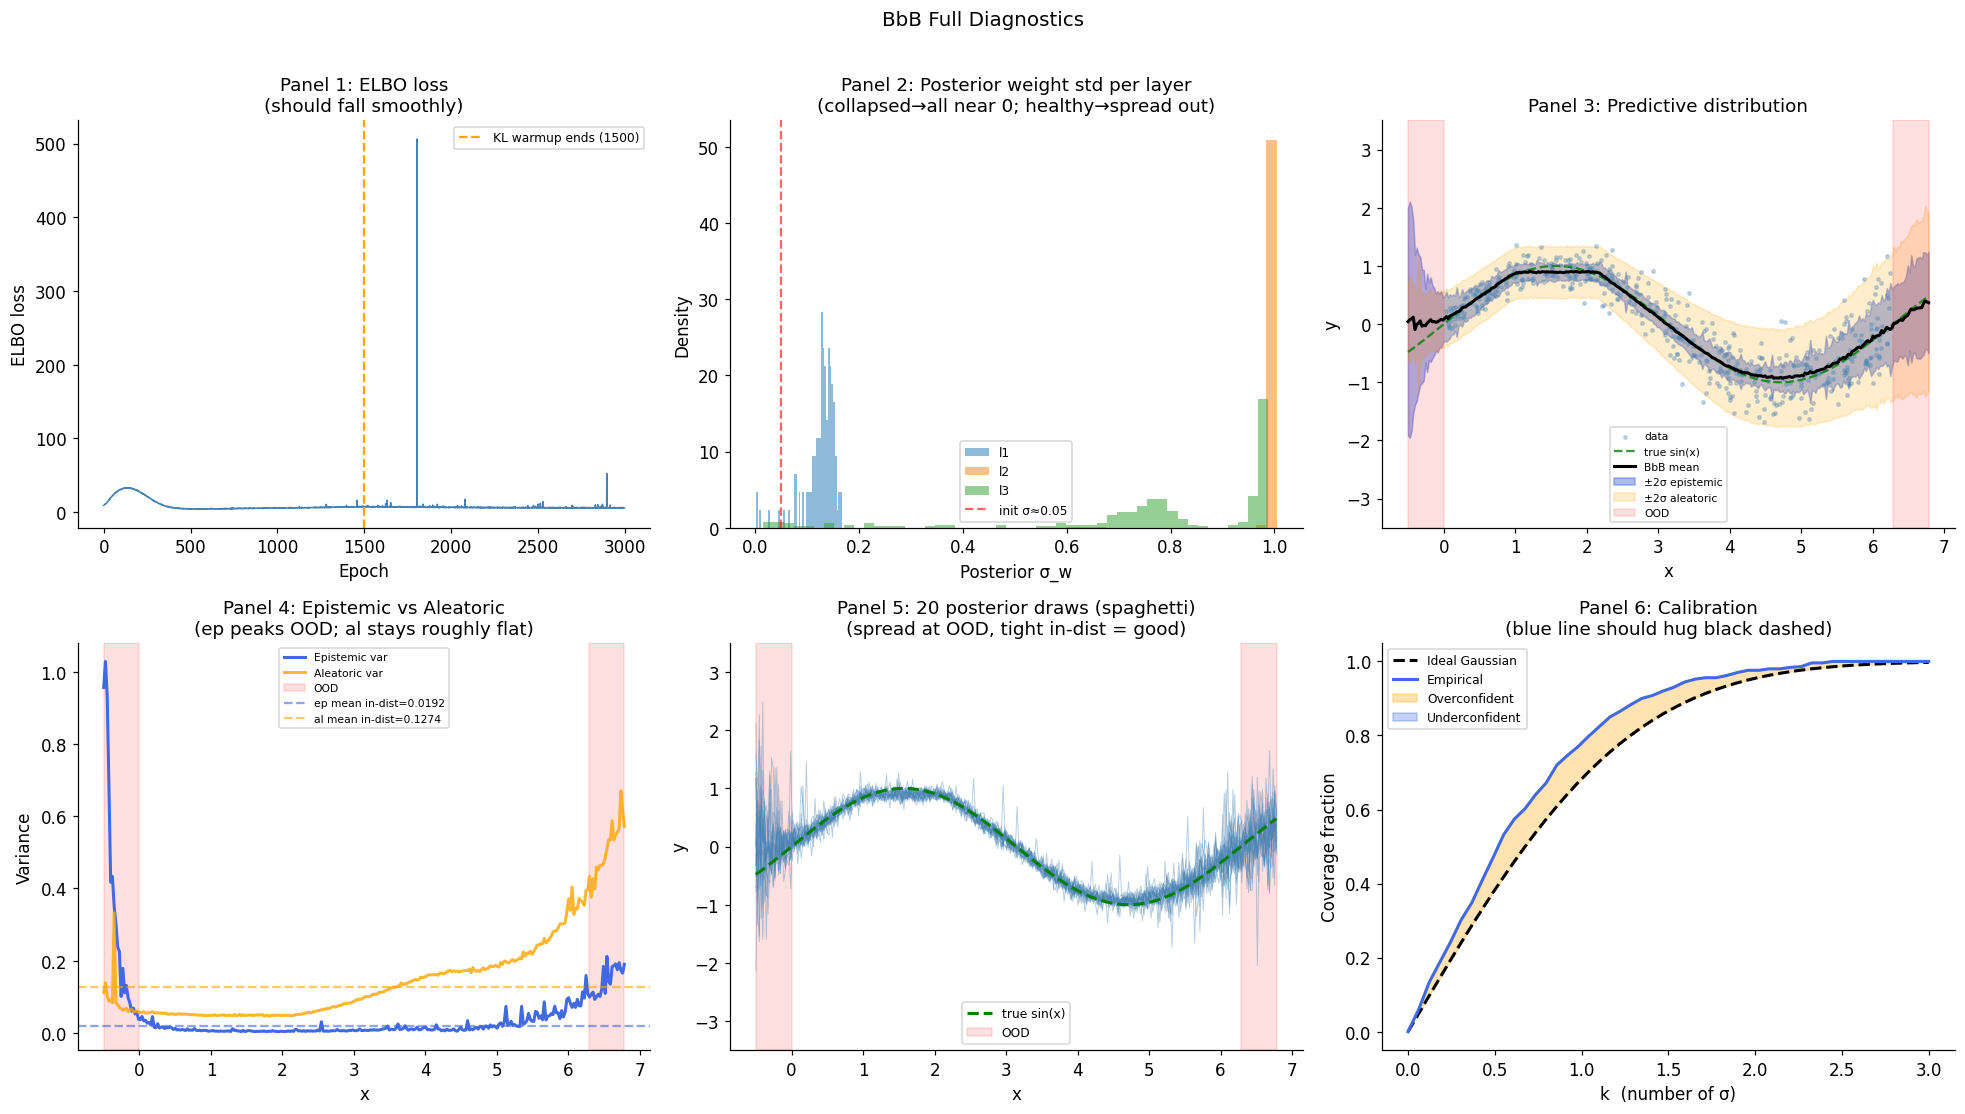

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm

def plot_bbb_diagnostics(model, bbb_losses, x_np, y_np, x_test_np,
                         bbb_mean, bbb_ep, bbb_al, kl_warmup=1500):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # ── Panel 1: ELBO loss ────────────────────────────────────────────────
    ax = axes[0]
    ax.plot(bbb_losses, lw=1, color="steelblue")
    ax.axvline(kl_warmup, ls="--", color="orange", label=f"KL warmup ends ({kl_warmup})")
    ax.set(xlabel="Epoch", ylabel="ELBO loss",
           title="Panel 1: ELBO loss\n(should fall smoothly)")
    ax.legend(fontsize=8)

    # ── Panel 2: Posterior std histogram per layer ────────────────────────
    # Shows whether posteriors have collapsed (all near 0) or are healthy
    ax = axes[1]
    for name in ["l1", "l2", "l3"]:
        layer = getattr(model, name)
        w_sigma = torch.nn.functional.softplus(layer.w_rho).detach().numpy()
        ax.hist(w_sigma.flatten(), bins=50, alpha=0.5, label=name, density=True)
    ax.axvline(0.05, ls="--", color="red", alpha=0.6, label="init σ≈0.05")
    ax.set(xlabel="Posterior σ_w", ylabel="Density",
           title="Panel 2: Posterior weight std per layer\n(collapsed→all near 0; healthy→spread out)")
    ax.legend(fontsize=8)

    # ── Panel 3: Predictive distribution ─────────────────────────────────
    ax = axes[2]
    ax.scatter(x_np, y_np, s=5, alpha=0.3, color="steelblue", label="data", zorder=2)
    ax.plot(x_test_np, np.sin(x_test_np), "g--", lw=1.5, alpha=0.8, label="true sin(x)", zorder=3)
    ax.plot(x_test_np, bbb_mean, "k-", lw=2, label="BbB mean", zorder=4)
    ax.fill_between(x_test_np,
                    bbb_mean - 2*np.sqrt(bbb_ep),
                    bbb_mean + 2*np.sqrt(bbb_ep),
                    alpha=0.45, color="royalblue", label="±2σ epistemic")
    ax.fill_between(x_test_np,
                    bbb_mean - 2*np.sqrt(bbb_al),
                    bbb_mean + 2*np.sqrt(bbb_al),
                    alpha=0.2, color="orange", label="±2σ aleatoric")
    ax.axvspan(-0.5, 0,              alpha=0.12, color="red", label="OOD")
    ax.axvspan(2*np.pi, 2*np.pi+0.5, alpha=0.12, color="red")
    ax.set_ylim(-3.5, 3.5)
    ax.set(xlabel="x", ylabel="y", title="Panel 3: Predictive distribution")
    ax.legend(fontsize=7)

    # ── Panel 4: Epistemic vs aleatoric separated ─────────────────────────
    # Key diagnostic: epistemic should peak at OOD, aleatoric should be flat
    ax = axes[3]
    in_dist = (x_test_np > 0) & (x_test_np < 2*np.pi)
    ax.plot(x_test_np, bbb_ep, "royalblue", lw=2, label="Epistemic var")
    ax.plot(x_test_np, bbb_al, "orange",    lw=2, label="Aleatoric var", alpha=0.8)
    ax.axvspan(-0.5, 0.0,              alpha=0.12, color="red", label="OOD")
    ax.axvspan(2*np.pi, 2*np.pi+0.5,   alpha=0.12, color="red")
    ax.axhline(bbb_ep[in_dist].mean(), ls="--", color="royalblue", alpha=0.6,
               label=f"ep mean in-dist={bbb_ep[in_dist].mean():.4f}")
    ax.axhline(bbb_al[in_dist].mean(), ls="--", color="orange",    alpha=0.6,
               label=f"al mean in-dist={bbb_al[in_dist].mean():.4f}")
    ax.set(xlabel="x", ylabel="Variance",
           title="Panel 4: Epistemic vs Aleatoric\n(ep peaks OOD; al stays roughly flat)")
    ax.legend(fontsize=7)

    # ── Panel 5: Spaghetti — 20 individual posterior weight draws ─────────
    # If draws spread at OOD and agree in-dist → posterior is well-calibrated
    ax = axes[4]
    X_test = torch.tensor(x_test_np[:, None], dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        for _ in range(20):
            mu, lv, _ = model(X_test)
            ax.plot(x_test_np, mu.numpy(), lw=0.6, alpha=0.4, color="steelblue")
    ax.plot(x_test_np, np.sin(x_test_np), "g--", lw=2, label="true sin(x)", zorder=5)
    ax.axvspan(-0.5, 0,              alpha=0.12, color="red", label="OOD")
    ax.axvspan(2*np.pi, 2*np.pi+0.5, alpha=0.12, color="red")
    ax.set_ylim(-3.5, 3.5)
    ax.set(xlabel="x", ylabel="y",
           title="Panel 5: 20 posterior draws (spaghetti)\n(spread at OOD, tight in-dist = good)")
    ax.legend(fontsize=8)

    # ── Panel 6: Calibration curve ────────────────────────────────────────
    # Asks: does ±kσ actually contain k-sigma fraction of training data?
    ax = axes[5]
    sigma_total = np.sqrt(bbb_ep + bbb_al)
    x_tr_idx    = np.argsort(x_np)
    x_sorted    = x_np[x_tr_idx];  y_sorted = y_np[x_tr_idx]
    mean_tr     = np.interp(x_sorted, x_test_np, bbb_mean)
    sigma_tr    = np.interp(x_sorted, x_test_np, sigma_total)
    residuals   = np.abs(y_sorted - mean_tr) / (sigma_tr + 1e-8)

    levels   = np.linspace(0, 3, 50)
    empirical = [np.mean(residuals < k) for k in levels]
    expected  = [2*norm.cdf(k) - 1    for k in levels]

    ax.plot(levels, expected,  "k--", lw=2, label="Ideal Gaussian")
    ax.plot(levels, empirical, "royalblue", lw=2, label="Empirical")
    ax.fill_between(levels, expected, empirical,
                    where=np.array(empirical) > np.array(expected),
                    alpha=0.3, color="orange",    label="Overconfident")
    ax.fill_between(levels, expected, empirical,
                    where=np.array(empirical) < np.array(expected),
                    alpha=0.3, color="royalblue", label="Underconfident")
    ax.set(xlabel="k  (number of σ)", ylabel="Coverage fraction",
           title="Panel 6: Calibration\n(blue line should hug black dashed)")
    ax.legend(fontsize=8)

    plt.suptitle("BbB Full Diagnostics", fontsize=13, y=1.01)
    plt.tight_layout()
    plt.savefig("bbb_diagnostics.png", dpi=150, bbox_inches="tight")
    plt.show()

# ── Call it after training ─────────────────────────────────────────────────
plot_bbb_diagnostics(bbb_model, bbb_losses, x_np, y_np, x_test_np,
                     bbb_mean, bbb_ep, bbb_al, kl_warmup=1500)


---
<a id='4'></a>
## 4. MC Dropout: Full Implementation and Diagnostics

MC Dropout is the cheapest method: no architecture changes, same parameter count. The **only** change from standard training is that dropout is **kept on at test time**.

**The BatchNorm trap:** calling `model.train()` at inference time to enable dropout will also put BatchNorm layers in train mode, causing them to update their running statistics with test data. This is silent data contamination. The correct pattern is:
1. `model.eval()` — freezes BatchNorm
2. Manually re-enable only `nn.Dropout` layers

We demonstrate this with a clean utility function `enable_dropout()`.

Training MC Dropout model...
Epoch  500 | NLL: -5.6412
Epoch 1000 | NLL: -6.0220
Epoch 1500 | NLL: -6.0413
Epoch 2000 | NLL: -6.2782


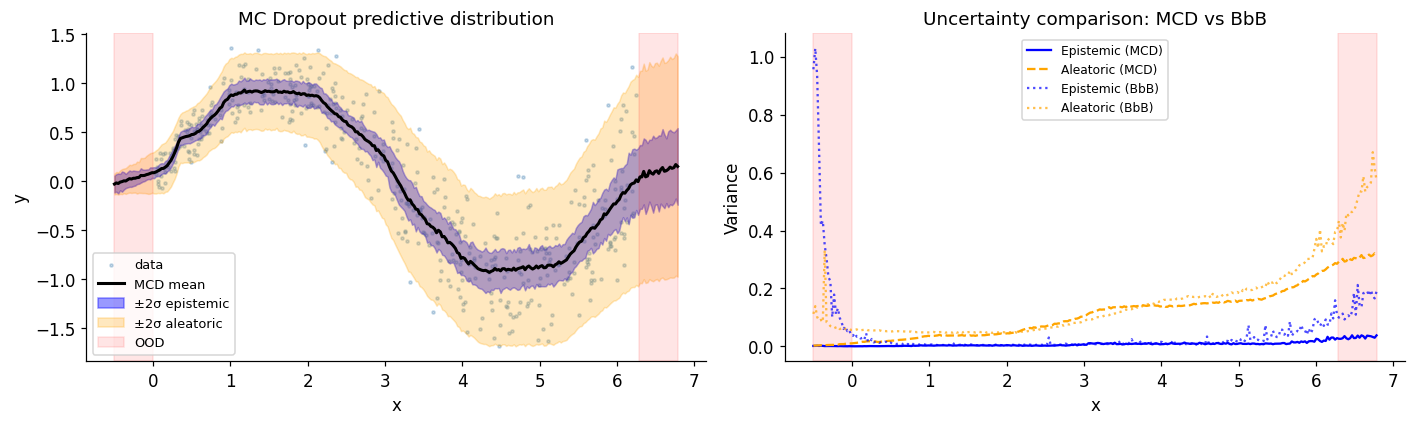

In [8]:
class MCDropoutNet(nn.Module):
    """
    Same architecture as BbBNet for fair comparison.
    ReLU instead of Tanh — critical for OOD epistemic uncertainty.
    Higher dropout p=0.3 for more posterior diversity.
    """
    def __init__(self, in_dim=1, hidden=128, p=0.3):  # hidden=128, p=0.3
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(p),  # ReLU not Tanh
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(p),  # ReLU not Tanh
            nn.Linear(hidden, 2),
        )
    def forward(self, x): return self.net(x)


def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()


def train_mcd(x_train, y_train,
              n_epochs=3000,    # same as BbB
              lr=1e-3,
              batch_size=64,
              p=0.3):           # p=0.3 not 0.2
    X = torch.tensor(x_train[:, None], dtype=torch.float32)
    Y = torch.tensor(y_train,          dtype=torch.float32)
    loader = DataLoader(TensorDataset(X, Y), batch_size=batch_size, shuffle=True)

    model = MCDropoutNet(1, 128, p)
    opt   = Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # weight decay = implicit prior
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(
                opt, T_max=n_epochs, eta_min=1e-4)
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in loader:
            opt.zero_grad()
            out  = model(xb)
            lv   = out[:, 1].clamp(-8, 4)
            loss = hetero_nll(yb, out[:, 0], lv)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            epoch_loss += loss.item()
        sched.step()
        losses.append(epoch_loss)
        if (epoch + 1) % 500 == 0:
            print(f'Epoch {epoch+1:4d} | NLL: {epoch_loss:.4f}')
    return model, losses


def mc_predict(model, x_test, T=200):   # T=200 same as BbB S=200
    X_test = torch.tensor(x_test[:, None], dtype=torch.float32)
    model.eval()
    enable_dropout(model)

    all_mu, all_al = [], []
    with torch.no_grad():
        for _ in range(T):
            out = model(X_test)
            all_mu.append(out[:, 0].numpy())
            all_al.append(torch.exp(out[:, 1].clamp(-8, 4)).numpy())

    all_mu = np.array(all_mu)
    all_al = np.array(all_al)
    mean   = all_mu.mean(0)
    ep_var = all_mu.var(0)
    al_var = all_al.mean(0)
    return mean, ep_var, al_var, ep_var + al_var


print('Training MC Dropout model...')
mcd_model, mcd_losses = train_mcd(x_np, y_np, n_epochs=2000, lr=1e-3, p=0.2)

mcd_mean, mcd_ep, mcd_al, mcd_tot = mc_predict(mcd_model, x_test_np, T=100)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

ax = axes[0]
ax.scatter(x_np, y_np, s=4, alpha=0.3, color='steelblue', label='data')
ax.plot(x_test_np, mcd_mean, 'k-', lw=2, label='MCD mean')
ax.fill_between(x_test_np,
                mcd_mean - 2*np.sqrt(mcd_ep),
                mcd_mean + 2*np.sqrt(mcd_ep),
                alpha=0.4, color='blue', label='±2σ epistemic')
ax.fill_between(x_test_np,
                mcd_mean - 2*np.sqrt(mcd_al),
                mcd_mean + 2*np.sqrt(mcd_al),
                alpha=0.25, color='orange', label='±2σ aleatoric')
ax.axvspan(-0.5, 0, alpha=0.1, color='red'); ax.axvspan(2*np.pi, 2*np.pi+0.5, alpha=0.1, color='red', label='OOD')
ax.set(xlabel='x', ylabel='y', title='MC Dropout predictive distribution')
ax.legend(fontsize=8.5)

ax = axes[1]
ax.plot(x_test_np, mcd_ep, 'b-', label='Epistemic (MCD)')
ax.plot(x_test_np, mcd_al, 'orange', ls='--', label='Aleatoric (MCD)')
ax.plot(x_test_np, bbb_ep, 'b:', label='Epistemic (BbB)', alpha=0.7)
ax.plot(x_test_np, bbb_al, ls=':', color='orange', label='Aleatoric (BbB)', alpha=0.7)
ax.axvspan(-0.5, 0, alpha=0.1, color='red'); ax.axvspan(2*np.pi, 2*np.pi+0.5, alpha=0.1, color='red')
ax.set(xlabel='x', ylabel='Variance', title='Uncertainty comparison: MCD vs BbB')
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

### Diagnostics

Good approximate inference must pass sanity checks. We verify two of the most important ones here.

Epoch  500 | NLL: -5.9543
n_extra=  0 | epochs=800 | ep_var=0.06339
Epoch  500 | NLL: -5.5917
n_extra= 10 | epochs=880 | ep_var=0.06449
Epoch  500 | NLL: -6.5652
Epoch 1000 | NLL: -6.9169
n_extra= 30 | epochs=1040 | ep_var=0.01825
Epoch  500 | NLL: -7.7561
Epoch 1000 | NLL: -7.3141
n_extra= 80 | epochs=1440 | ep_var=0.01417
Epoch  500 | NLL: -9.1704
Epoch 1000 | NLL: -9.7783
Epoch 1500 | NLL: -9.7495
Epoch 2000 | NLL: -9.9978
n_extra=200 | epochs=2400 | ep_var=0.00452


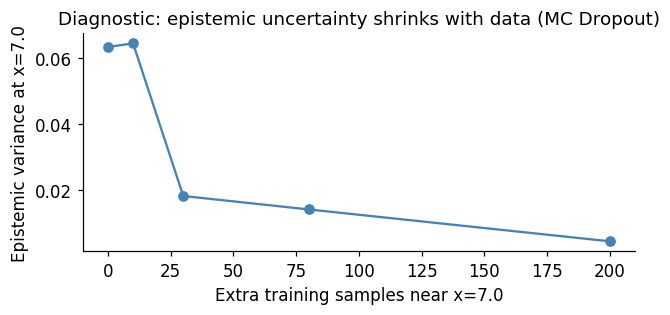

SOFT PASS: overall decreasing but not monotone.


In [9]:
import random

def set_seed(s=42):
    torch.manual_seed(s); np.random.seed(s); random.seed(s)

x_focus = np.float32(7.0)
ep_vs_n = []
n_extra_list = [0, 10, 30, 80, 200]

for n_extra in n_extra_list:
    set_seed(42)   # ← same init every run — isolates the data effect

    x_aug = np.concatenate([x_np,
              np.linspace(6.3, 7.2, n_extra).astype(np.float32)])
    y_aug = np.concatenate([y_np,
              (np.sin(np.linspace(6.3, 7.2, n_extra))
               + 0.15*np.random.randn(n_extra)).astype(np.float32)])

    # epochs scale with dataset size so the model actually converges
    n_ep = 800 + n_extra * 8     # ← was fixed 800 for all sizes
    m, _ = train_mcd(x_aug, y_aug,
                     n_epochs=n_ep,
                     lr=1e-3,
                     p=0.3)      # ← was 0.2

    _, ep, _, _ = mc_predict(m, np.array([x_focus]), T=100)
    ep_vs_n.append(ep[0])
    print(f'n_extra={n_extra:3d} | epochs={n_ep} | ep_var={ep[0]:.5f}')

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(n_extra_list, ep_vs_n, 'o-', color='steelblue')
ax.set(xlabel='Extra training samples near x=7.0',
       ylabel='Epistemic variance at x=7.0',
       title='Diagnostic: epistemic uncertainty shrinks with data (MC Dropout)')
plt.tight_layout()
plt.show()

# Check
diffs = [ep_vs_n[i+1] - ep_vs_n[i] for i in range(len(ep_vs_n)-1)]
if all(d <= 0 for d in diffs):
    print('PASSED: monotonically decreasing.')
elif ep_vs_n[-1] < ep_vs_n[0]:
    print('SOFT PASS: overall decreasing but not monotone.')
else:
    print('FAILED: still not decreasing — try increasing n_ep multiplier.')


---
<a id='5'></a>
## 5. Why VI when MC Dropout is so Simple? — Empirical Comparison

We compare MC Dropout and Bayes-by-Backprop on two metrics:
1. **Negative log-likelihood (NLL)** on a held-out test set — a proper scoring rule for uncertainty quality.
2. **Epistemic uncertainty in OOD region** — does the method correctly flag unfamiliar inputs?

**The punchline (anticipated):**
- MCD is easier to implement and works well as a baseline.
- BbB can give better-calibrated posteriors when the prior std is tuned, because it explicitly optimises a KL objective — the posterior width per weight is a direct output of the optimisation, not an indirect consequence of dropout rate.
- MCD uncertainty is sensitive to the dropout rate `p`; BbB uncertainty is controlled by `prior_std`.
- For safety-critical biomedical applications, investing in BbB or ensembles is warranted.

=== Held-out NLL comparison ===
MC Dropout  — In-dist NLL: 0.155   OOD NLL: 0.969
BbB         — In-dist NLL: 0.199   OOD NLL: 1.045


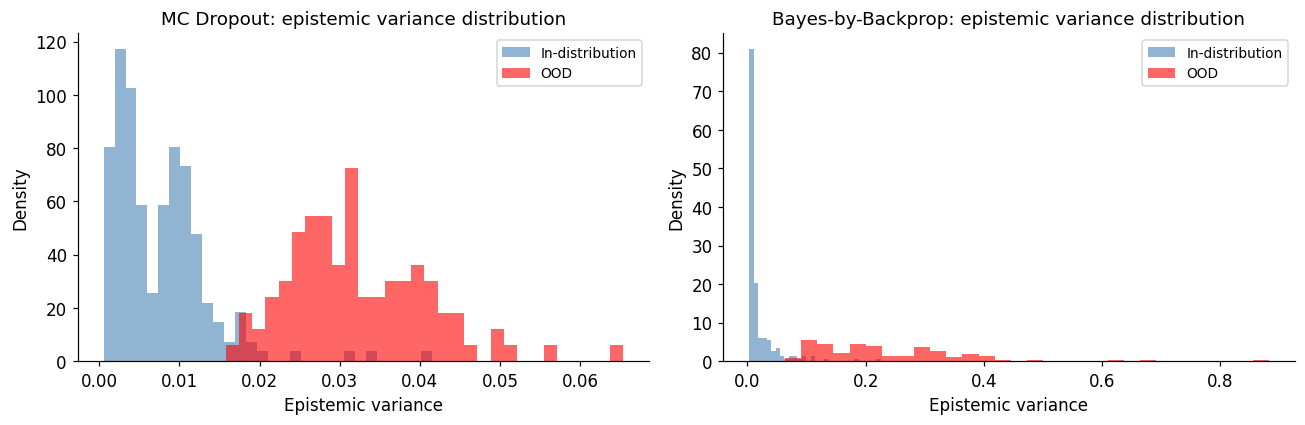


Interpretation:
  - OOD distribution (red) should be shifted right vs in-distribution (blue)
  - Both methods should show this separation; BbB often shows cleaner separation
  - Lower NLL = better calibrated uncertainty (not just accuracy)


In [10]:
# ── Held-out NLL comparison ──
# Test set: data in [0, 2pi] and OOD in [2pi, 2pi+1]
np.random.seed(0)
x_test_eval = np.concatenate([
    np.random.uniform(0, 2*np.pi, 200),      # in-distribution
    np.random.uniform(2*np.pi, 2*np.pi+1, 100)  # OOD
]).astype(np.float32)
noise_test = 0.1 + 0.4 * x_test_eval / (2*np.pi)
y_test_eval = (np.sin(x_test_eval) + np.random.normal(0, noise_test)).astype(np.float32)

def gaussian_nll_np(y_true, mu, var):
    """Gaussian NLL in numpy."""
    return 0.5 * (np.log(2*np.pi*var) + (y_true - mu)**2 / var).mean()

# MCD predictions on test set
mcd_m, mcd_ep_t, mcd_al_t, mcd_tot_t = mc_predict(mcd_model, x_test_eval, T=50)
nll_mcd_id  = gaussian_nll_np(y_test_eval[:200], mcd_m[:200], mcd_tot_t[:200])
nll_mcd_ood = gaussian_nll_np(y_test_eval[200:], mcd_m[200:], mcd_tot_t[200:])

# BbB predictions on test set
bbb_m, bbb_ep_t, bbb_al_t = bbb_predict(bbb_model, x_test_eval, S=50)
bbb_tot_t = bbb_ep_t + bbb_al_t
nll_bbb_id  = gaussian_nll_np(y_test_eval[:200], bbb_m[:200], bbb_tot_t[:200])
nll_bbb_ood = gaussian_nll_np(y_test_eval[200:], bbb_m[200:], bbb_tot_t[200:])

print('=== Held-out NLL comparison ===')
print(f'MC Dropout  — In-dist NLL: {nll_mcd_id:.3f}   OOD NLL: {nll_mcd_ood:.3f}')
print(f'BbB         — In-dist NLL: {nll_bbb_id:.3f}   OOD NLL: {nll_bbb_ood:.3f}')

# Plot epistemic uncertainty at OOD vs in-distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, method, ep_id, ep_ood, name in [
    (axes[0], 'MC Dropout', mcd_ep_t[:200], mcd_ep_t[200:], 'MCD'),
    (axes[1], 'Bayes-by-Backprop', bbb_ep_t[:200], bbb_ep_t[200:], 'BbB'),
]:
    ax.hist(ep_id, bins=30, alpha=0.6, color='steelblue', label='In-distribution', density=True)
    ax.hist(ep_ood, bins=30, alpha=0.6, color='red', label='OOD', density=True)
    ax.set(xlabel='Epistemic variance', ylabel='Density',
           title=f'{method}: epistemic variance distribution')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()
print()
print('Interpretation:')
print('  - OOD distribution (red) should be shifted right vs in-distribution (blue)')
print('  - Both methods should show this separation; BbB often shows cleaner separation')
print('  - Lower NLL = better calibrated uncertainty (not just accuracy)')

---
## Summary and Practical Recommendations

| Method | When to use | Implementation effort | Uncertainty quality |
|--------|-------------|----------------------|--------------------|
| **MC Dropout** | Existing model with dropout, rapid prototyping | Very low | Good baseline |
| **Bayes-by-Backprop** | New architecture, need principled posterior widths | Medium | Better calibration |
| **SGLD** | Small models, ground-truth benchmark | Medium (careful tuning) | Asymptotically exact |
| **Deep Ensembles** | Safety-critical, best UQ quality needed | High ($M\times$ training) | Best empirical |

**For biomedical applications specifically:**
- Always use the **heteroscedastic loss** — physiological signals have highly variable noise levels.
- Use **mutual information** as the OOD metric for classification (arrhythmia, seizure).
- Track **epistemic vs aleatoric** separately — they warrant different clinical responses.
- Validate that **epistemic uncertainty shrinks with more training data** (mandatory sanity check).
- Report **NLL on a held-out set** as your primary uncertainty quality metric, not accuracy alone.